In [1]:
import uuid
from dataclasses import dataclass, field
from datetime import datetime


@dataclass(frozen=True)
class Event:
    tenant_id: uuid.UUID = field(repr=False)
    event_time: datetime

    event_op_code: int
    event_user_id: int
    event_folder_id: int

    event_id: uuid.UUID = field(default_factory=uuid.uuid4, repr=False)

    def encode(self):
        return [
            int(self.event_time.timestamp()),
            int(self.event_op_code),
            int(self.event_user_id),
            int(self.event_folder_id)
        ]

In [2]:
from datetime import date


def generate_event(
        tenant_id: uuid.UUID, event_date: date, operation: int, event_user_id: int, event_folder_id: int
):
    return Event(
        tenant_id=tenant_id,
        event_time=datetime.combine(event_date, datetime.min.time()),
        event_op_code=operation,
        event_user_id=event_user_id,
        event_folder_id=event_folder_id
    )


def setup_event_generator(tenant_id: uuid.UUID):
    def internal(event_date: date, operation: int, event_user_id: int, event_folder_id: int):
        return generate_event(tenant_id, event_date, operation, event_user_id, event_folder_id)

    return internal

In [3]:
import random
from datetime import timedelta

tenant_id = uuid.uuid4()
generate_event_fn = setup_event_generator(tenant_id)

year = [datetime.today() + timedelta(days=x) for x in range(365)]
month = year[:30]
week = year[:7]

opcodes = [1001, 1001, 1002, 1003, 1004]
users = [x for x in range(50)]
folders = [x for x in range(250)]

# generate 500 events with random days, opcodes, users, folders choices
events = [
    generate_event_fn(random.choice(year), random.choice(opcodes), random.choice(users), random.choice(folders))
    for x in range(100_000)
]

embeddings = [x.encode() for x in events]

In [4]:
def normalize_list(data: list[int]):
    min_value = min(data)
    max_value = max(data)

    for i in range(len(data)):
        data[i] = (data[i] - min_value) / (max_value - min_value)
    return data


def normalize_list_of_list(data: list[list[int]]):
    num_columns = len(data[0])

    items = []
    for col_index in range(num_columns):
        columns = [row[col_index] for row in data]
        items.append(normalize_list(columns))

    return [list(x) for x in zip(*items)]

In [5]:
time_axis = [x[0] for x in embeddings]
print(min(time_axis), max(time_axis), random.choices(time_axis, k=5))

time_axis = normalize_list(time_axis)
print(min(time_axis), max(time_axis), random.choices(time_axis, k=5))

time_axis = normalize_list_of_list([[1, 0.1], [2, 0.2], [3, 0.3]])
print(min(time_axis), max(time_axis), random.choices(time_axis, k=5))

1743030000 1774479600 [1744668000, 1773097200, 1772751600, 1750888800, 1760911200]
0.0 1.0 [0.7692307692307693, 0.7307692307692307, 0.19219322344322345, 0.7142857142857143, 0.6593406593406593]
[0.0, 0.0] [1.0, 1.0] [[1.0, 1.0], [1.0, 1.0], [0.0, 0.0], [0.5, 0.5000000000000001], [0.5, 0.5000000000000001]]


In [6]:
import matplotlib.pyplot as plt

time_axis = [x[0] for x in embeddings]
# time_axis = normalize_list(time_axis)

op_code_axis = [x[1] for x in embeddings]
# op_code_axis = normalize_list(op_code_axis)

user_id_axis = [x[2] for x in embeddings]
# user_id_axis = normalize_list(user_id_axis)

folder_id_axis = [x[2] for x in embeddings]
# object_axis = normalize_list(folder_id_axis)

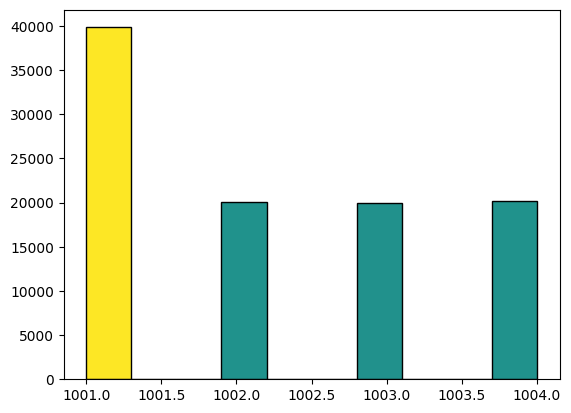

In [7]:
cnts, values, bars = plt.hist(op_code_axis, edgecolor='k')

cmap = plt.cm.viridis
for i, (cnt, value, bar) in enumerate(zip(cnts, values, bars)):
    bar.set_facecolor(cmap(cnt / cnts.max()))

plt.show()

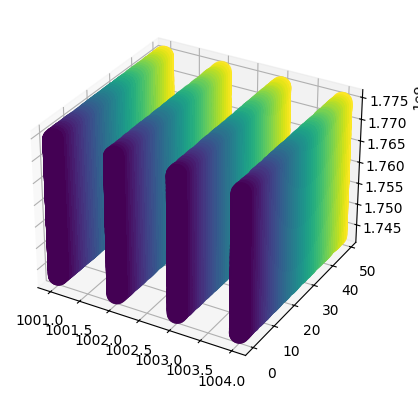

In [8]:
ax = plt.axes(projection='3d')
ax.scatter3D(xs=op_code_axis, ys=user_id_axis, zs=time_axis, c=user_id_axis, s=200)
plt.show()

In [9]:
from tqdm import tqdm
import chromadb
from chromadb.utils.batch_utils import create_batches

client = chromadb.PersistentClient()

if "events" in client.list_collections():
    client.delete_collection("events")

collection = client.create_collection("events", metadata={
    "hnsw:space": "l2",
    # "hnsw:space": "cosine",
    # "hnsw:construction_ef": 100 * 10,
    # "hnsw:search_ef": 100 * 10,
    # "hnsw:M": 16,
})

metadata = {"source": "events", "tenant_id": str(tenant_id)}
# embeddings = normalize_list_of_list(embeddings)

batches = list(create_batches(
    api=client,
    ids=list([str(event.event_id) for event in events]),
    documents=list([str(event) for event in events]),
    metadatas=list([metadata | {"event_time": event.event_time.timestamp()} for event in events]),
    embeddings=list(embeddings))
)
for ids, embeddings, metadatas, documents in tqdm(batches):
    collection.add(ids=ids, embeddings=embeddings, documents=documents, metadatas=metadatas)

100%|██████████| 3/3 [02:13<00:00, 44.63s/it]


In [10]:
event = generate_event_fn(random.choice(month), random.choice(opcodes), random.choice(users), random.choice(folders))

print(event)
results = collection.query(
    [event.encode()],
    where={"$and": [
        {"source": "events"},
        {"tenant_id": str(tenant_id)},
        {"event_time": {"$gt": (event.event_time - timedelta(days=3)).timestamp()}},
        {"event_time": {"$lt": (event.event_time + timedelta(days=3)).timestamp()}},
    ]},
    n_results=50,
    include=["documents", "distances"]
)
for doc, distance in zip(results["documents"][0], results["distances"][0]):
    print(distance, doc)

Event(event_time=datetime.datetime(2025, 4, 19, 0, 0), event_op_code=1004, event_user_id=12, event_folder_id=244)
5.0 Event(event_time=datetime.datetime(2025, 4, 19, 0, 0), event_op_code=1002, event_user_id=11, event_folder_id=244)
26.0 Event(event_time=datetime.datetime(2025, 4, 19, 0, 0), event_op_code=1001, event_user_id=16, event_folder_id=243)
38.0 Event(event_time=datetime.datetime(2025, 4, 19, 0, 0), event_op_code=1003, event_user_id=6, event_folder_id=245)
67.0 Event(event_time=datetime.datetime(2025, 4, 19, 0, 0), event_op_code=1001, event_user_id=5, event_folder_id=241)
137.0 Event(event_time=datetime.datetime(2025, 4, 19, 0, 0), event_op_code=1001, event_user_id=20, event_folder_id=236)
146.0 Event(event_time=datetime.datetime(2025, 4, 19, 0, 0), event_op_code=1001, event_user_id=1, event_folder_id=248)
179.0 Event(event_time=datetime.datetime(2025, 4, 19, 0, 0), event_op_code=1001, event_user_id=1, event_folder_id=237)
198.0 Event(event_time=datetime.datetime(2025, 4, 19, 0